In [1]:
import numpy as np
import random

In [2]:
SEED = 1234

In [3]:
# Set seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [5]:
# Read from CSV to Pandas DataFrame
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [6]:
df.shape

(1000, 3)

In [7]:
# Define X and y
X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values

In [8]:
list(df['tumor_class'].unique())

['benign', 'malignant']

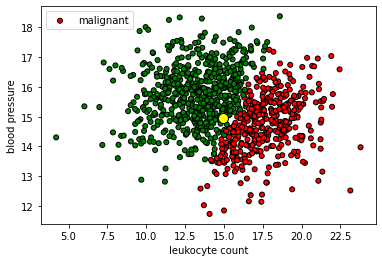

In [9]:
# Plot data
colors = {"benign": "red", "malignant": "green"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors="k")
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(["malignant", "benign"], loc="upper left")
plt.scatter(x=14.95081332 , y=14.95081332, marker="o",c='yellow',s=100,edgecolors="k")
plt.show()

In [10]:
import collections
from sklearn.model_selection import train_test_split

In [11]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [12]:
def train_val_test_split(X, y, train_size):
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


In [14]:
# Overall class distribution
class_counts = dict(collections.Counter(y))
print (f"Classes: {class_counts}")
print (f'm:b = {class_counts["malignant"]/class_counts["benign"]:.2f}')

Classes: {'benign': 389, 'malignant': 611}
m:b = 1.57


In [15]:
# Per data split class distribution
train_class_counts = dict(collections.Counter(y_train))
val_class_counts = dict(collections.Counter(y_val))
test_class_counts = dict(collections.Counter(y_test))
train_ratio = train_class_counts["malignant"]/train_class_counts["benign"]
val_ratio = val_class_counts["malignant"]/val_class_counts["benign"]
test_ratio = test_class_counts["malignant"]/test_class_counts["benign"]
print (f"train m:b = {train_ratio:.2f}")
print (f"val m:b = {val_ratio:.2f}")
print (f"test m:b = {test_ratio:.2f}")

train m:b = 1.57
val m:b = 1.54
test m:b = 1.59


### Label Encoding

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [17]:
le.fit(y_train)

LabelEncoder()

In [18]:
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [19]:
# Class weights
counts = np.bincount(y_train)

In [20]:
class_weights = {i: 1.0/count for i, count in enumerate(counts)}

In [21]:
print (f"counts: {counts}\nweights: {class_weights}")

counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


## Standardize Data

In [22]:
from sklearn.preprocessing import StandardScaler

In [23]:
X_scaler = StandardScaler().fit(X_train)   # train only on X_train to avoid any biases

In [24]:
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

In [25]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")


X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


In [28]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
NUM_CLASSES = len(le.classes_) # y has two possibilities (benign or malignant)

## Now the Model

In [32]:
import torch
from torch import nn
import torch.nn.functional as F

In [33]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes)

    def forward(self, x_in):
        z = self.fc1(x_in)
        return z


In [34]:
# Initialize model
model = LogisticRegression(input_dim=INPUT_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)

<bound method Module.named_parameters of LogisticRegression(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)>


In [36]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [45]:
class_weights

{0: 0.003676470588235294, 1: 0.002336448598130841}

In [37]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [39]:
from torch.optim import Adam

In [41]:
LEARNING_RATE = 1e-1

In [42]:
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [43]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

In [44]:
NUM_EPOCHS = 1000

In [54]:
y_pred = model(X_train)
y_pred[-5:]

tensor([[ 0.2538,  0.4666],
        [-0.0203,  0.0474],
        [-0.2678, -0.3134],
        [ 0.7685,  1.2289],
        [ 0.8551,  1.3665]], grad_fn=<SliceBackward0>)

In [50]:
loss = loss_fn(y_pred, y_train)
loss

tensor(0.8121, grad_fn=<NllLossBackward0>)

In [55]:
predictions = y_pred.max(dim=1)[1] # class
predictions[-5:]

tensor([1, 1, 0, 1, 1])

In [63]:
# Training
for epoch in range(NUM_EPOCHS):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


Epoch: 0 | loss: 0.81, accuracy: 41.0
Epoch: 10 | loss: 0.23, accuracy: 94.4
Epoch: 20 | loss: 0.14, accuracy: 96.1
Epoch: 30 | loss: 0.11, accuracy: 97.9
Epoch: 40 | loss: 0.09, accuracy: 98.0
Epoch: 50 | loss: 0.08, accuracy: 98.1
Epoch: 60 | loss: 0.08, accuracy: 98.0
Epoch: 70 | loss: 0.07, accuracy: 98.0
Epoch: 80 | loss: 0.07, accuracy: 98.1
Epoch: 90 | loss: 0.07, accuracy: 98.1
Epoch: 100 | loss: 0.07, accuracy: 98.4
Epoch: 110 | loss: 0.06, accuracy: 98.4
Epoch: 120 | loss: 0.06, accuracy: 98.4
Epoch: 130 | loss: 0.06, accuracy: 98.4
Epoch: 140 | loss: 0.06, accuracy: 98.4
Epoch: 150 | loss: 0.06, accuracy: 98.4
Epoch: 160 | loss: 0.05, accuracy: 98.4
Epoch: 170 | loss: 0.05, accuracy: 98.6
Epoch: 180 | loss: 0.05, accuracy: 98.6
Epoch: 190 | loss: 0.05, accuracy: 98.6
Epoch: 200 | loss: 0.05, accuracy: 98.6
Epoch: 210 | loss: 0.05, accuracy: 98.6
Epoch: 220 | loss: 0.05, accuracy: 98.6
Epoch: 230 | loss: 0.05, accuracy: 98.6
Epoch: 240 | loss: 0.05, accuracy: 98.6
Epoch: 250 

In [64]:
from sklearn.metrics import accuracy_score

In [74]:
# Predictions
pred_train = F.softmax(model(X_train), dim=1)
pred_test = F.softmax(model(X_test), dim=1)
print (f"sample probability: {pred_test[0]}")
pred_train = pred_train.max(dim=1)[1]
pred_test = pred_test.max(dim=1)[1]
print (f"sample class: {pred_test[0]}")

sample probability: tensor([1.5281e-05, 9.9998e-01], grad_fn=<SelectBackward0>)
sample class: 1


In [75]:
# Accuracy (could've also used our own accuracy function)
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")

train acc: 0.99, test acc: 0.99


In [76]:


import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [77]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance


In [80]:
# # Performance
performance = get_metrics(y_true=y_test, y_pred=pred_test, classes=le.classes_)
print (json.dumps(performance, indent=2))

{
  "overall": {
    "precision": 0.9869503546099291,
    "recall": 0.9866666666666667,
    "f1": 0.9866213921901529,
    "num_samples": 150.0
  },
  "class": {
    "benign": {
      "precision": 1.0,
      "recall": 0.9655172413793104,
      "f1": 0.9824561403508771,
      "num_samples": 58.0
    },
    "malignant": {
      "precision": 0.9787234042553191,
      "recall": 1.0,
      "f1": 0.989247311827957,
      "num_samples": 92.0
    }
  }
}
